In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from datetime import datetime 

#from pandas_datareader import data as pdr
#from pandas_datareader.data import DataReader
#import yfinance as yf

In [2]:
df=pd.read_csv("indexData.csv")
df.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0


In [3]:
df.shape

(112457, 8)

In [4]:
df.dtypes

Index         object
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [5]:
df.Date=pd.to_datetime(df.Date)

In [6]:
df=df.set_index("Date")

In [7]:
df.head()

,Index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1965-12-31,NYA,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1966-01-03,NYA,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
1966-01-04,NYA,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
1966-01-05,NYA,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
1966-01-06,NYA,532.070007,532.070007,532.070007,532.070007,532.070007,0.0


In [8]:
df["Index"].unique()

array(['NYA', 'IXIC', 'HSI', '000001.SS', 'GSPTSE', '399001.SZ', 'NSEI',
       'GDAXI', 'KS11', 'SSMI', 'TWII', 'J203.JO', 'N225', 'N100'],
      dtype=object)

In [9]:
df=df.query("Index == 'NYA'").query("Date>'2018-01-01'")

In [10]:
df.dtypes

Index         object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [11]:
df=df[["Close"]] #univeriate time data.

In [12]:
df

,Close
Date,
2018-01-02,12902.71973
2018-01-03,12957.28027
2018-01-04,13028.45996
2018-01-05,13103.23047
2018-01-08,13114.34961
...,...
2021-05-24,16464.68945
2021-05-25,16390.18945
2021-05-26,16451.96094


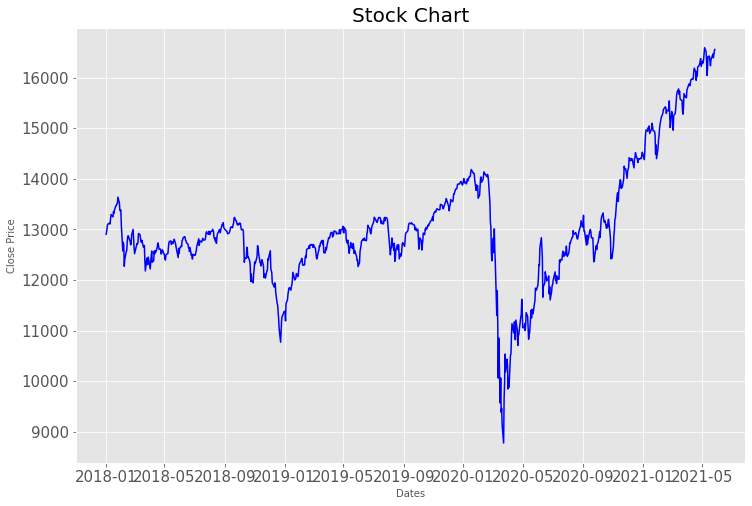

In [13]:
plt.style.use("ggplot")
plt.figure(figsize=(12,8))
plt.grid(True)
plt.xlabel("Dates",fontsize=10)
plt.xticks(fontsize=15)
plt.ylabel("Close Price",fontsize=10)
plt.yticks(fontsize=15)
plt.plot(df["Close"], color="blue")
plt.title("Stock Chart", fontsize=20)
plt.show()

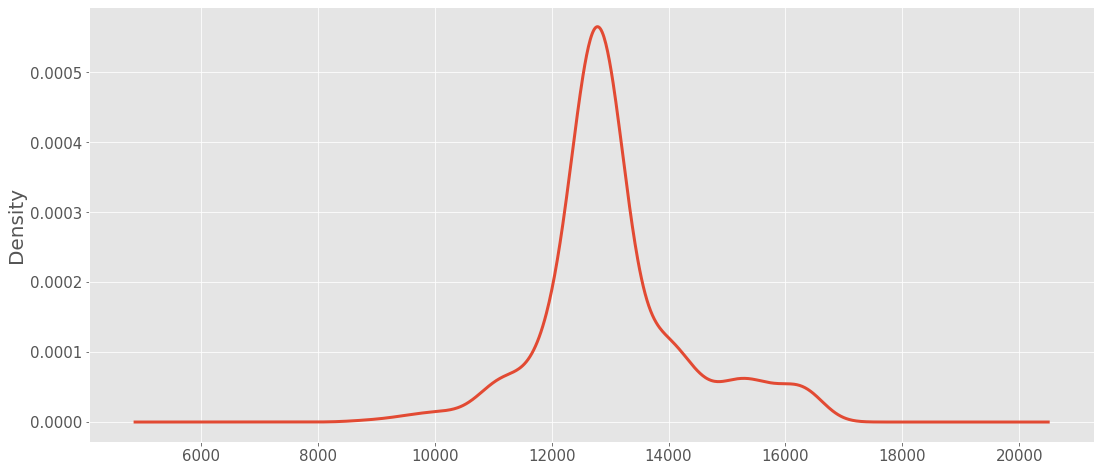

In [14]:
#Let's plot the distribution(dist_plot) of the closing price.
df_close= df["Close"]
df_close.plot(kind="kde",figsize=(18,8),linewidth=3)
plt.xticks(fontsize=15)
plt.grid("both")
plt.ylabel("Density",fontsize=20)
plt.yticks(fontsize=15)
plt.show()

### ADF(Augumented Dickey-Fuller) Test

The Dickey-Fuller Test is one of the most extensively used statistical tests. It can be used to establish whether a series has a unit root and, as a result , whether the series is stationary. The null and alternate hypothesis for the test are:
Distinguish between point to point links and multi point links.

Null Hypothesis: The series has a unit root(a=1)/ Non stationary.

Alternative Hypothesis: There is no unit root in the series/ Stationary.

The series is considered to be stationary if the null hypothesis is rejected. As a result, the series can be linear or difference stationary. If both the mean and standard deviation are flat lines, the series becomes stationary(constant mean and constant variance).

In [15]:
df.isnull().sum()

Close    0
dtype: int64

In [16]:
df["Close"].fillna(540,inplace=True)

In [17]:
df.isnull().sum()

Close    0
dtype: int64

In [18]:
df.dtypes

Close    float64
dtype: object

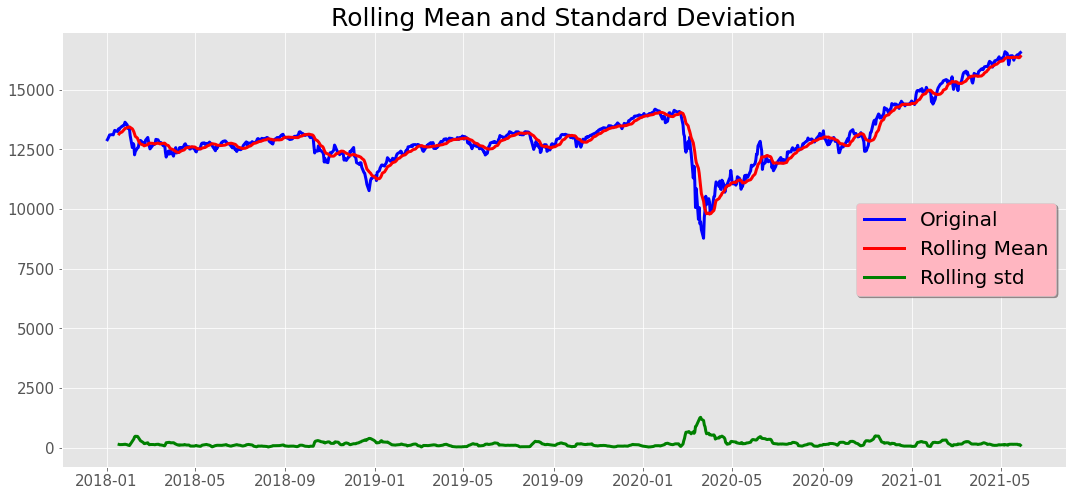

In [19]:
#test for stationary
def test_stationary(timeseries):
    #Determining rolling statistics
    rolmean= timeseries.rolling(12).mean() #rolling mean #we took window size=12.
    rolstd= timeseries.rolling(12).std() #rolling standard deviation
    
    #plot rolling statistics:
    plt.figure(figsize=(18,8))
    plt.grid("both")
    plt.plot(timeseries,color="blue", label="Original", linewidth=3)
    plt.plot(rolmean,color="red", label="Rolling Mean", linewidth=3)
    plt.plot(rolstd,color="green", label="Rolling std", linewidth=3)
    plt.legend(loc="best",fontsize=20,shadow=True,facecolor="lightpink")
    plt.title("Rolling Mean and Standard Deviation", fontsize=25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show(block=False)
       
test_stationary(df_close)

In [20]:
print("Result of dickey fuller test")
adft= adfuller(df, autolag="AIC")
output=pd.Series(adft[0:4],index=["Test statistics", "p_value", "No.of lags used", "Number of Observation used"])
output

Result of dickey fuller test


Test statistics                -1.177570
p_value                         0.683169
No.of lags used                 9.000000
Number of Observation used    848.000000
dtype: float64

In [21]:
adft= adfuller(df, autolag="AIC")
adft

(-1.1775703323571003,
 0.6831692122740711,
 9,
 848,
 {'1%': -3.4380849118778234,
  '5%': -2.86495432618506,
  '10%': -2.5685880571933963},
 10800.344398336236)

we can't reject the Null Hypothesis because the p-value is bigger than 0.05. Furthermore, the test statistics exceed the criteria values. As a result, the data is not stationary. 

Differencing is a method of transforming a non- stationary time series into a stationary one. This is an important step in preparing data to be used in an ARIMA model. So to make the data stationary, we need to take the first order difference of the data. Which is just another way of saying, subtract today's close price from yesterday's close price.

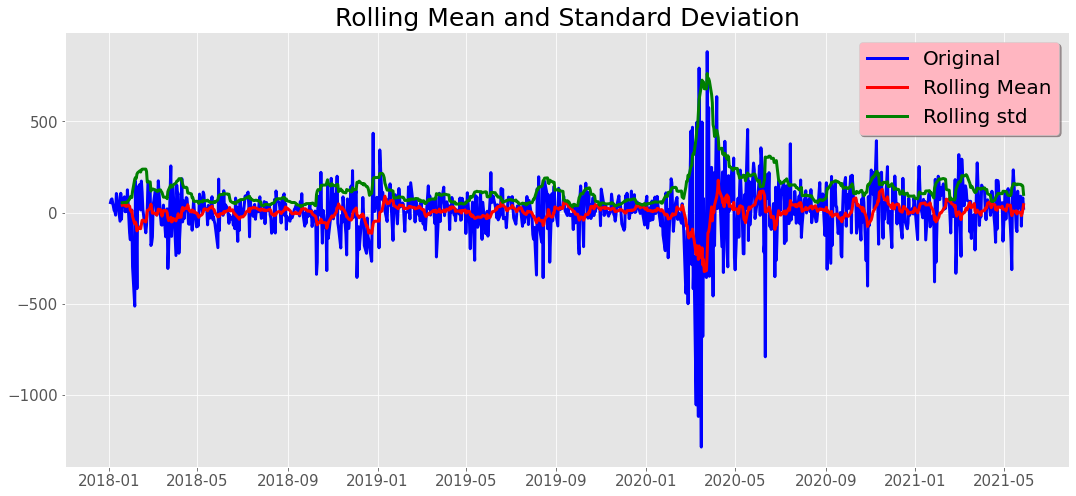

In [22]:
#get the difference of each Adj Close Point
#do differencing until it convert into stationary data where mean and variance are constant.
#lets plot the 1st order difference.
Close_diff1= df_close.diff()
Close_diff1.dropna(inplace=True)
test_stationary(Close_diff1)

In [23]:
df_close.diff()  #we will get NAN. So we have to remove that NAN.

Date
2018-01-02         NaN
2018-01-03    54.56054
2018-01-04    71.17969
2018-01-05    74.77051
2018-01-08    11.11914
                ...   
2021-05-24    89.68945
2021-05-25   -74.50000
2021-05-26    61.77149
2021-05-27    79.98828
2021-05-28    23.71094
Name: Close, Length: 858, dtype: float64

In [24]:
print("Result of dickey fuller test")
adft= adfuller(Close_diff1, autolag="AIC")
output=pd.Series(adft[0:4],index=["Test statistics", "p_value", "No.of lags used", "Number of Observation used"])
output

Result of dickey fuller test


Test statistics              -8.550321e+00
p_value                       9.260950e-14
No.of lags used               8.000000e+00
Number of Observation used    8.480000e+02
dtype: float64

we got the P_value less than 0.05. so we got the stationary. We reject the null hypothesis.

Decompose the time Series: To start with, we want to decompose the data to seperate the seasonality, trend and residual. Since we have 3 yrs of stock data. we would expect there's a yearly and weekly pattern. Let's use a function seasonal_decompose in statsmodel to help us find it.

<Figure size 1440x720 with 0 Axes>

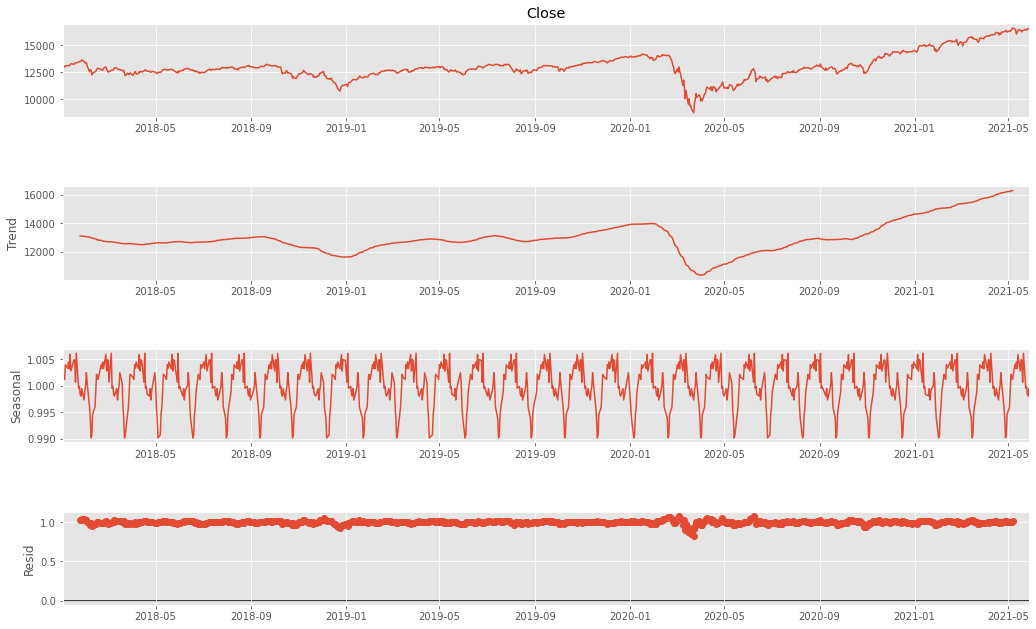

In [25]:
result= seasonal_decompose(df["Close"],model="multiplicative",period=30)
fig=plt.figure(figsize=(20,10))
fig=result.plot()
fig.set_size_inches(17,10)

In [26]:
#split the data into train and test data.

In [27]:
train_data=df_close[0:-80]
test_data=df_close[-80:]
#if we have 200 data then, we will take 0-120th data as train and 120-200 as test.

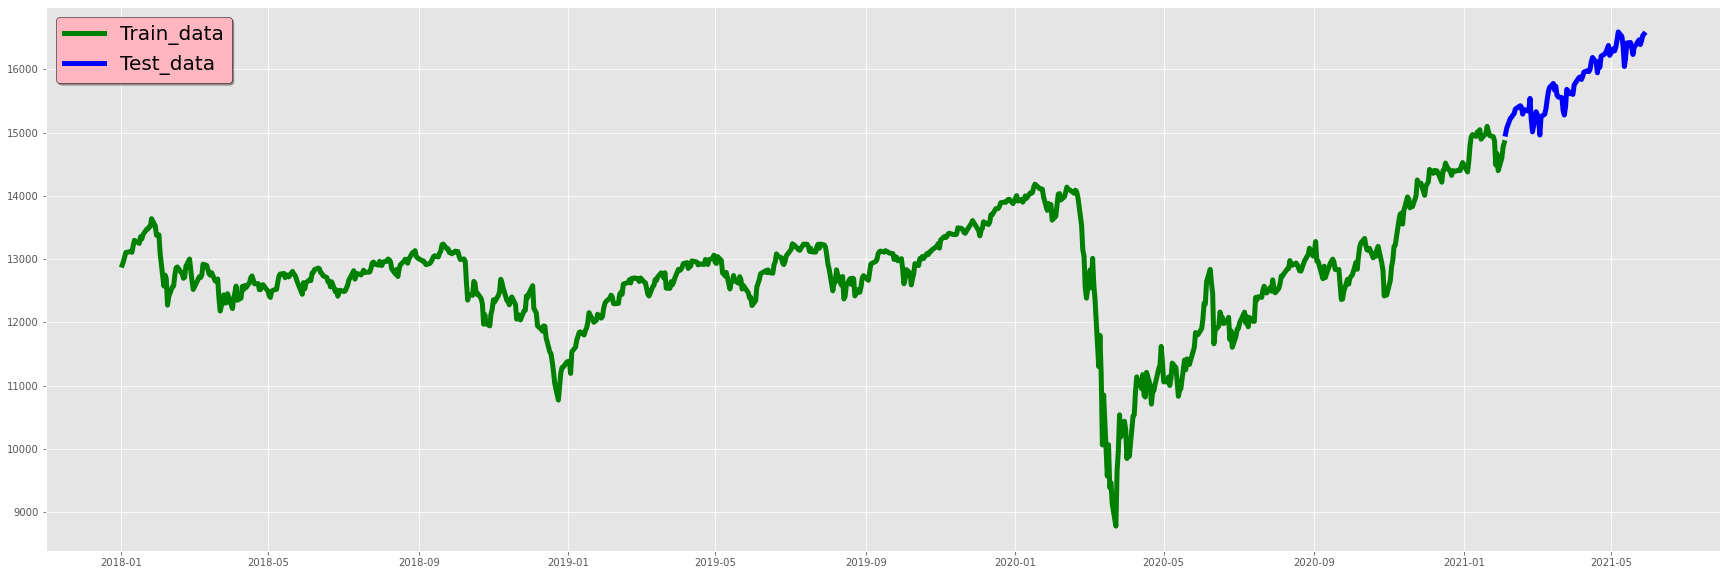

In [28]:
plt.figure(figsize=(30,10))
plt.plot(train_data,"green", label="Train_data", linewidth=5)
plt.plot(test_data,"blue", label="Test_data", linewidth=5)
plt.legend(fontsize=20, shadow=True, facecolor="lightpink", edgecolor="k")

Autocorrelation function:
After time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series.

By looking at the autocorrelation function(ACF) and partial autocorrelation (PACF) plots of the differenced series, we can tentatively identify the numbers of AR and MA terms that are needed.

#### Autocorrelation Function Plot(ACF):
Autocorrelation refers to how correlated a time series is with its past values whereas the ACF is the plot used to see the correlation between the points, up to and including the lag unit. In ACF, the correlation coefficinet is in the X_axis whereas the number of lags is shown in the y_axis.

Normally, we employ either the AR terms or the MA in an ARIMA model. Both of these Phrases are rarely used on rare occasions. The ACF plot is used to determine which of these terms we should utilise for our time series.

--> If the autocorrelation at lag 1 is positive, we utilise the AR model.

--> If the autocorrelation at lag 1 is negative, we utilise the MA model.

We move on to Partial Autocorrelation function plots (PACF) after plotting the ACF plot.

#### Partial Autocorrelation Function Plot(PACF):
A partial autocorrelation is a summary of the relationship between an observation in a time series with observation at prior time steps with the relationship of intervening observations removed. The partial autocorrelation at lag k is the correlation that result after removing the effect of any correlation. 
If the PACF plot drops off at lag n, then use an AR(n) model and if the drop in PACF is more gradual then we use the MA terms.


Use AR terms in the model when the, 
--> ACF plots show autocorrelation decaying towards zero

--> PACF plot cuts off quickly towards zero

--> ACF of a stationary series shows positive at lag-1

Use MA terms in the model when the model is, 

--> Negatively autocorrelated at Lag -1

--> ACF that drops sharply after a few lags

--> PACF decreases more gradually.

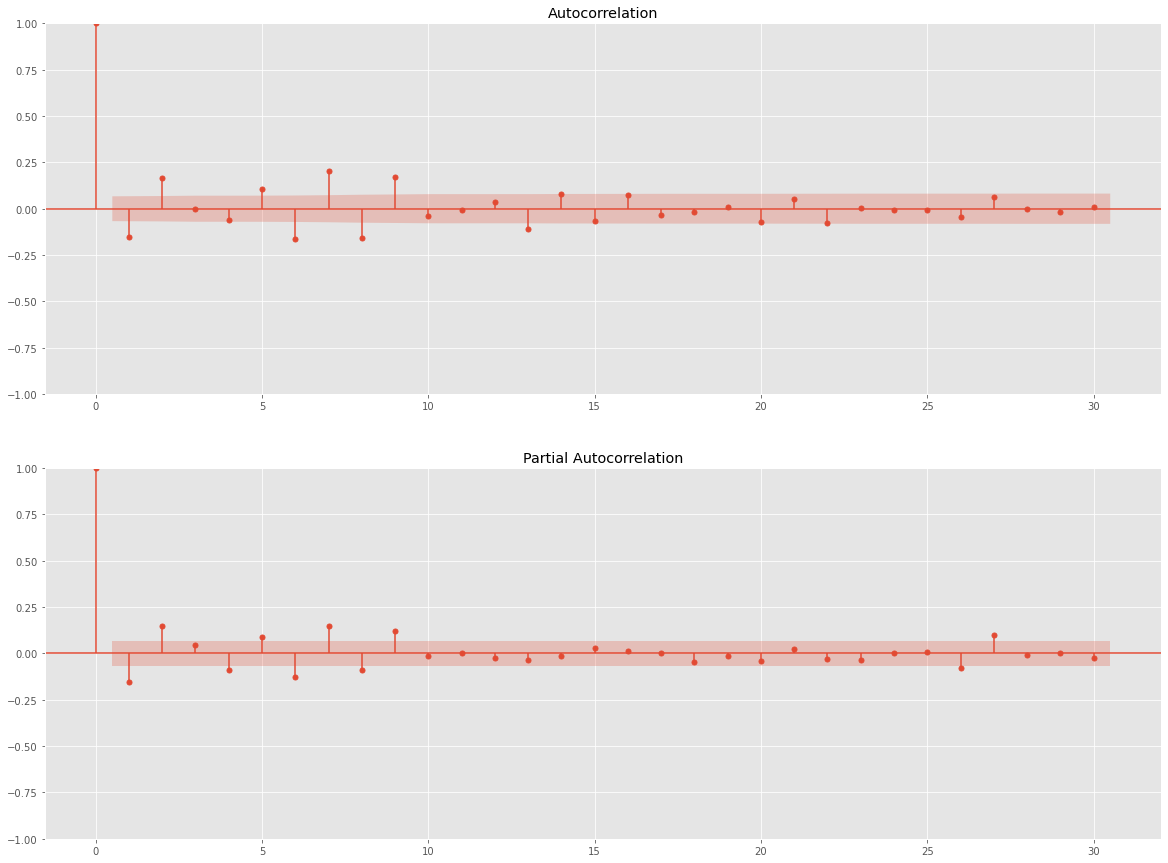

In [29]:
fig= plt.figure(figsize=(20,15))
ax1=fig.add_subplot(211)
fig=plot_acf(Close_diff1,ax=ax1)
ax2=fig.add_subplot(212)
fig=plot_pacf(Close_diff1,ax=ax2)

In [30]:
pd.DataFrame(train_data)

,Close
Date,
2018-01-02,12902.71973
2018-01-03,12957.28027
2018-01-04,13028.45996
2018-01-05,13103.23047
2018-01-08,13114.34961
...,...
2021-01-28,14669.51953
2021-01-29,14397.20020
2021-02-01,14596.17969


In [31]:
model1= auto_arima(train_data, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10094.642, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10134.658, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10116.574, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10121.923, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10132.838, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10093.046, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=10091.154, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=10092.930, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10109.916, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10094.722, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=10089.326, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10120.161, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=10091.217, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=10091.105, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0

In [32]:
warnings.filterwarnings("ignore")
model = ARIMA(train_data,order=(0,1,2)).fit()
round(model.params,2)

ma.L1        -0.13
ma.L2         0.21
sigma2    25308.52
dtype: float64

In [33]:
history=[x for x in train_data]
prediction=list()
for t in range(len(test_data)):
    model=ARIMA(history, order=(0,1,2))
    model_fit=model.fit()
    fc=model_fit.forecast(alpha=0.05)
    prediction.append(fc)
    history.append(test_data[t])
print("RMSE of ARIMA model", np.sqrt(mean_absolute_error(test_data,prediction)))

RMSE of ARIMA model 10.207116122295634


In [34]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  857
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -5542.860
Date:                Sun, 24 Dec 2023   AIC                          11091.721
Time:                        03:17:17   BIC                          11105.978
Sample:                             0   HQIC                         11097.180
                                - 857                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1272      0.015     -8.221      0.000      -0.158      -0.097
ma.L2          0.1812      0.014     12.725      0.000       0.153       0.209
sigma2      2.465e+04    480.204     51.327      0.000    2.37e+04    2.56e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              4390.53
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                            -1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
test_data[0:10]

Date
2021-02-04    14975.42969
2021-02-05    15069.59961
2021-02-08    15226.61035
2021-02-09    15244.40039
2021-02-10    15273.90039
2021-02-11    15297.08984
2021-02-12    15369.59961
2021-02-16    15423.01953
2021-02-17    15402.58984
2021-02-18    15290.63965
Name: Close, dtype: float64

In [36]:
prediction[0:10]

[array([14878.1029801]),
 array([14977.3603771]),
 array([15077.96160393]),
 array([15226.52954512]),
 array([15273.82149583]),
 array([15277.70964716]),
 array([15294.52595352]),
 array([15363.75486557]),
 array([15431.20805896]),
 array([15419.06337836])]

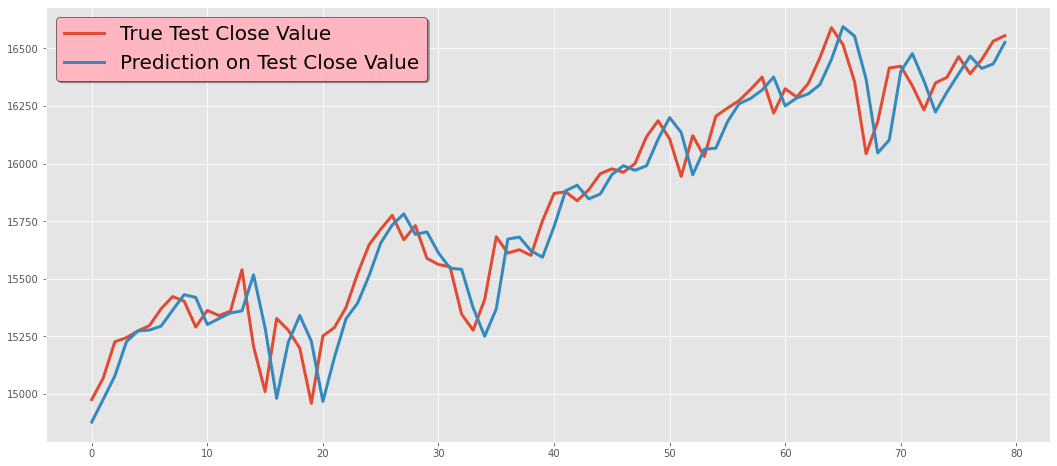

In [37]:
plt.figure(figsize=(18,8))
plt.grid(True)
plt.plot(range(len(test_data)),test_data,label="True Test Close Value", linewidth=3)
plt.plot(range(len(prediction)),prediction, label="Prediction on Test Close Value", linewidth=3)
plt.legend(fontsize=20, shadow=True, edgecolor="k", facecolor="lightpink")
plt.show()

In [38]:
#Forecasting the next 60 days data.

In [39]:
df_close.shape

(858,)

In [40]:
from statsmodels.graphics.tsaplots import plot_predict


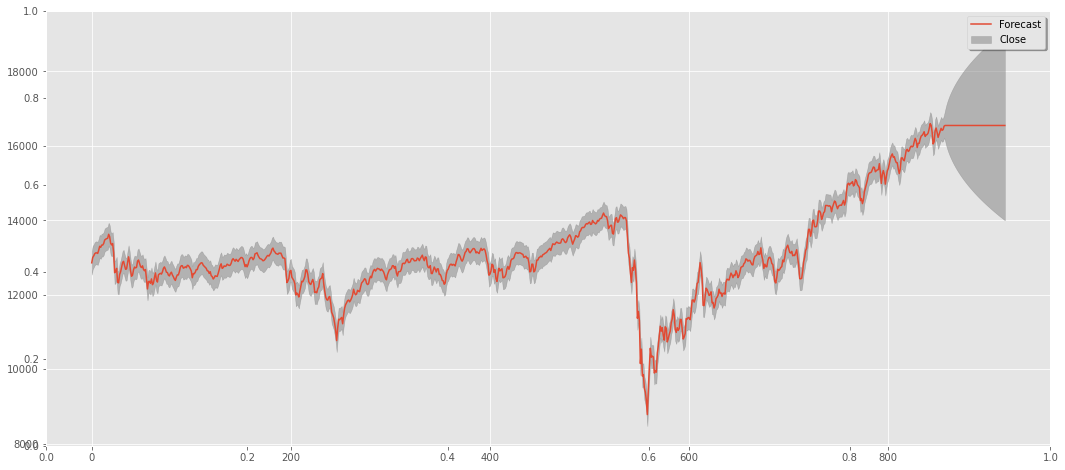

In [41]:
fig, ax = plt.subplots(figsize=(18,8))
ax=fig.add_subplot(111)
plot_predict(model_fit, start=1, end=len(df_close)+60, ax=ax)
plt.grid("both")
plt.legend(["Forecast","Close","95% confidence Interval"], fontsize=10, shadow=True)
plt.show()

Although our model is good but this model has trouble forecasting long-term data. This is possible because ARIMA is sensitive alogithm and not a broad algorithm for predicting. Stock data on the other hand, rarely show seasonality that can be detected using the ARIMA model. Forecasting is thought to be easier if there is a visible or hidden pattern that repeats itself throughout time. Stock prices on the other hand as far too complicated to be modelled. There are so may external and dynamic factor affecting the price.

Just like ARIMA , SARIMA has two order value, order of all data and Seasonal order. 